⚠️ GPU が利用できません。CPU で実行します。
🚀 モデルの学習を開始します...
Epoch 1/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.2558 - loss: 3.6549 - val_accuracy: 0.3665 - val_loss: 2.4035
Epoch 2/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3772 - loss: 2.0939 - val_accuracy: 0.3971 - val_loss: 1.8950
Epoch 3/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3964 - loss: 1.8986 - val_accuracy: 0.4008 - val_loss: 1.8073
Epoch 4/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.4038 - loss: 1.8171 - val_accuracy: 0.4018 - val_loss: 1.7466
Epoch 5/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.4140 - loss: 1.7713 - val_accuracy: 0.4096 - val_loss: 1.7239
Epoch 6/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4182 - loss: 1.7433 - val_accuracy: 0.4179 - val_loss: 1.6862
Epoch 7/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4193 - loss: 1.7169 - val_accuracy: 0.4210 - val_loss: 1.6872
Epoch 8/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/st

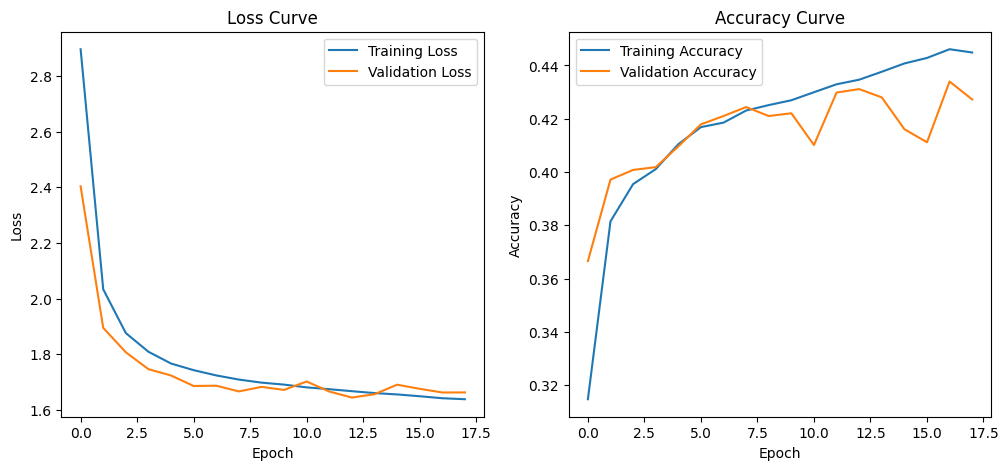

✅ 改良版 CNN + LSTM モデルの学習が完了しました。
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4246 - loss: 1.6927 
Test Loss: 1.6783
Test Accuracy: 0.4254


In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Conv1D, MaxPooling1D, Flatten, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 🚀 TensorFlowのOneDNN最適化を無効化
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# 🚀 GPU の使用を確認
if len(tf.config.experimental.list_physical_devices('GPU')) == 0:
    print("⚠️ GPU が利用できません。CPU で実行します。")
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
else:
    print("✅ GPU が利用可能です。")

# データ保存先
DATA_DIR = "./data/"

# 特徴量とラベルをロード
X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
y_train = np.load(os.path.join(DATA_DIR, "y_train.npy"))
X_val = np.load(os.path.join(DATA_DIR, "X_val.npy"))
y_val = np.load(os.path.join(DATA_DIR, "y_val.npy"))
X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))
y_test = np.load(os.path.join(DATA_DIR, "y_test.npy"))

# 🚀 データの正規化（Min-Max スケーリング）
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# 🚀 LSTM に適したデータ形状に変換（[サンプル数, 時系列長, 特徴量数]）
sequence_length = X_train.shape[1]
X_train = X_train.reshape((X_train.shape[0], sequence_length, 1))
X_val = X_val.reshape((X_val.shape[0], sequence_length, 1))
X_test = X_test.reshape((X_test.shape[0], sequence_length, 1))

# 🚀 クラスバランスを考慮
y_labels = np.argmax(y_train, axis=1)  # One-hot をクラスラベルに変換
class_weights = compute_class_weight('balanced', classes=np.unique(y_labels), y=y_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 🚀 CNN + LSTM モデル構築（修正）
model = Sequential([
    Input(shape=(sequence_length, 1)),  

    # 🚀 CNN層
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    # 🚀 LSTM層
    Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.002))),
    Dropout(0.5),
    Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.002))),
    Dropout(0.5),

    # 🚀 全結合層
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[-1], activation='softmax')  # 🚀 クラス数を確実に取得
])

# 🚀 モデルのコンパイル（学習率を調整）
model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# 🚀 Early Stopping の追加
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 🚀 モデルの学習
print("🚀 モデルの学習を開始します...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,  # クラスバランスを考慮
    callbacks=[early_stopping],
    verbose=1
)
print("✅ モデルの学習が完了しました。")

# 🚀 学習曲線の可視化
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# 🚀 モデルの保存
model_path = os.path.join(DATA_DIR, "cnn_lstm_model_improved.keras")
model.save(model_path)
print("✅ 改良版 CNN + LSTM モデルの学習が完了しました。")

# 🚀 モデルの評価
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")